In [229]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
# import bcolz
import seaborn as sns
import os
import matplotlib.pyplot as plt

%matplotlib inline
data_path = "drive/My Drive/DATA KAGGLE/"
seed=1204
# def save_array(fname, arr):
#     """
#     save numpy array to file
#     """
#     c=bcolz.carray(arr, rootdir=fname, mode='w')
#     c.flush()

# def load_array(fname):
#     return bcolz.open(fname)[:]

def get_submission(test,item_cnt_month):
    sub = test.copy()
    sub['item_cnt_month'] = item_cnt_month
    sub.drop(['item_id','shop_id'],axis=1,inplace=True)
    sub.to_csv(data_path + 'submission.csv',index=False)
    return sub

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder



In [0]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

In [0]:
transactions    = pd.read_csv(os.path.join(data_path, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(data_path, 'items.csv'))
item_categories = pd.read_csv(os.path.join(data_path, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(data_path, 'shops.csv'))
test            = pd.read_csv(os.path.join(data_path, 'test.csv.gz'))

In [175]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [176]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# Distribution of items sold and items price

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


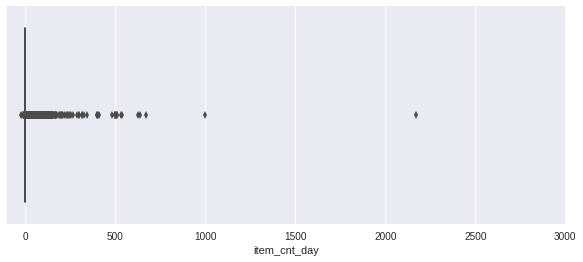

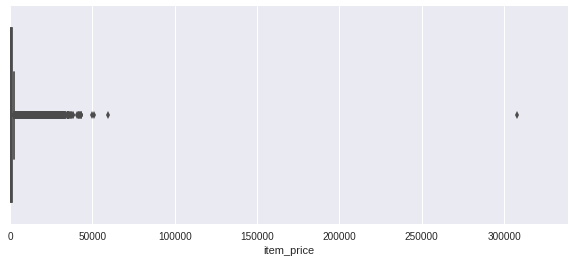

In [177]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=transactions.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_price.min(), transactions.item_price.max()*1.1)
sns.boxplot(x=transactions.item_price)

In [0]:
transactions = transactions[transactions.item_price<100000]
transactions = transactions[transactions.item_cnt_day<1001]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


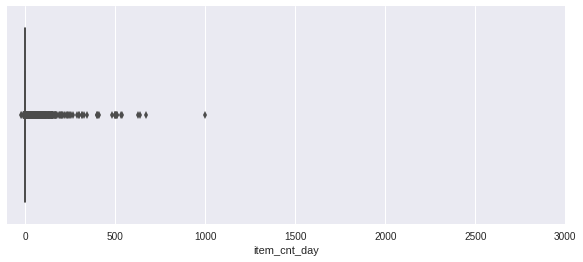

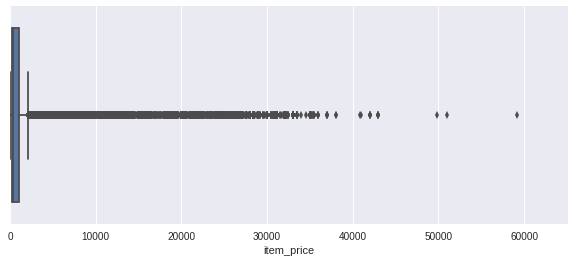

In [179]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=transactions.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(transactions.item_price.min(), transactions.item_price.max()*1.1)
sns.boxplot(x=transactions.item_price)

In [180]:
transactions.item_cnt_day.describe()

count    2.935847e+06
mean     1.241903e+00
std      2.292963e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+03
Name: item_cnt_day, dtype: float64

In [181]:
transactions.item_price.describe()

count    2.935847e+06
mean     8.907489e+02
std      1.720490e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      5.920000e+04
Name: item_price, dtype: float64

## Imputing Outliers

In [0]:
median = transactions[(transactions.shop_id==32)&(transactions.item_id==2973)&(transactions.date_block_num==4)&(transactions.item_price>0)].item_price.median()
transactions.loc[transactions.item_price<0, 'item_price'] = median

In [0]:
# Якутск Орджоникидзе, 56
transactions.loc[transactions.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
transactions.loc[transactions.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
transactions.loc[transactions.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [184]:
shops.head()
# type(shops)
# list(shops.columns.values)
# list(shops)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# Creating the features grid

## Creating a grid of distinct shop, item and month

In [203]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates to get rid of duplicates
gb = transactions.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [204]:
gb.head()

,shop_id,item_id,date_block_num,item_cnt_day
,,,,target
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [205]:
print(gb.columns.values)

[('shop_id', '') ('item_id', '') ('date_block_num', '')
 ('item_cnt_day', 'target')]


In [206]:
for col in gb.columns.values:
  print(col[0])
  print(col[-1]) 
  print(col) 

shop_id

('shop_id', '')
item_id

('item_id', '')
date_block_num

('date_block_num', '')
item_cnt_day
target
('item_cnt_day', 'target')


In [207]:
# Fix column names
print(gb.columns.values)
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
print(gb.columns.values)

[('shop_id', '') ('item_id', '') ('date_block_num', '')
 ('item_cnt_day', 'target')]
['shop_id' 'item_id' 'date_block_num' 'target']


In [208]:
print(gb.columns.values)

['shop_id' 'item_id' 'date_block_num' 'target']


In [209]:
gb.head()

,shop_id,item_id,date_block_num,target
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [210]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [0]:
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [0]:
# merge with category id
all_data =pd.merge(all_data,items,on=['item_id'],how='left')

In [213]:
items.head()
all_data.head()

,shop_id,item_id,date_block_num,target,item_name,item_category_id
0,59,22154,0,1.0,ЯВЛЕНИЕ 2012 (BD),37
1,59,2552,0,0.0,DEEP PURPLE The House Of Blue Light LP,58
2,59,2554,0,0.0,DEEP PURPLE Who Do You Think We Are LP,58
3,59,2555,0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56
4,59,2564,0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59


## Aggregates of monthly- shop/item/item category levels

In [214]:
#shop-month aggregates
gb = transactions.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'shop_block_target_sum':'sum','shop_block_target_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [215]:
#item-month aggregates
gb = transactions.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'item_block_target_sum':'sum','item_block_target_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [217]:
#item category-month aggregates
transactions =pd.merge(transactions,items,on=['item_id'],how='left')
gb = transactions.groupby(['item_category_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'item_cat_block_target_sum':'sum','item_cat_block_target_mean':np.mean}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [0]:
def downcast_dtypes(df):
    '''
    Changes column types in the dataframe: 

    `float64` type to `float32`
    `int64`   type to `int32`
    '''

    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]

    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)

    return df


In [218]:
all_data.shape

(10913804, 12)

In [220]:
downcast_dtypes(all_data)

,shop_id,item_id,date_block_num,target,item_name,item_category_id,shop_block_target_sum,shop_block_target_mean,item_block_target_sum,item_block_target_mean,item_cat_block_target_sum,item_cat_block_target_mean
0,59,22154,0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2017.0,1.092041,18.0,1.000000,6094.0,1.053414
1,59,2552,0,0.0,DEEP PURPLE The House Of Blue Light LP,58,2017.0,1.092041,0.0,0.000000,287.0,0.969595
2,59,2554,0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,2017.0,1.092041,1.0,1.000000,287.0,0.969595
3,59,2555,0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2017.0,1.092041,2.0,1.000000,268.0,1.007519
4,59,2564,0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,2017.0,1.092041,5.0,1.000000,701.0,0.990113
5,59,2565,0,0.0,DEEP PURPLE Stormbringer (фирм.),56,2017.0,1.092041,2.0,1.000000,268.0,1.007519
6,59,2572,0,0.0,DEFTONES Koi No Yokan,55,2017.0,1.092041,12.0,1.000000,12527.0,1.025878
7,59,2573,0,0.0,DEL REY LANA Born To Die,55,2017.0,1.092041,16.0,1.142857,12527.0,1.025878
8,59,2574,0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,2017.0,1.092041,119.0,1.144231,12527.0,1.025878
9,59,2593,0,0.0,DEPECHE MODE Music For The Masses,55,2017.0,1.092041,5.0,1.000000,12527.0,1.025878


In [226]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_name,item_category_id,shop_block_target_sum,shop_block_target_mean,item_block_target_sum,item_block_target_mean,item_cat_block_target_sum,item_cat_block_target_mean
0,59,22154,0,1.0,ЯВЛЕНИЕ 2012 (BD),37,2017.0,1.092041,18.0,1.0,6094.0,1.053414
1,59,2552,0,0.0,DEEP PURPLE The House Of Blue Light LP,58,2017.0,1.092041,0.0,0.0,287.0,0.969595
2,59,2554,0,0.0,DEEP PURPLE Who Do You Think We Are LP,58,2017.0,1.092041,1.0,1.0,287.0,0.969595
3,59,2555,0,0.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,2017.0,1.092041,2.0,1.0,268.0,1.007519
4,59,2564,0,0.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,2017.0,1.092041,5.0,1.0,701.0,0.990113


In [0]:
data_path = "gdrive/My Drive/DATA KAGGLE/"

In [0]:
all_data.to_csv(data_path+'new_sales_v1_reduced.csv',index=False)